In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

J1: Start- 11/1/2015  12:00:00 AM End- 6/30/2017  11:00:00 PM 

J2: Start- 11/1/2015  12:00:00 AM End- 6/30/2017  11:00:00 PM 

J3: Start- 11/1/2015  12:00:00 AM End- 6/30/2017  11:00:00 PM

J4: Start- 1/1/2017  12:00:00 AM  End- 6/30/2017  11:00:00 PM

In [ ]:
data = pd.read_csv("/content/traffic.csv")

In [ ]:
data

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

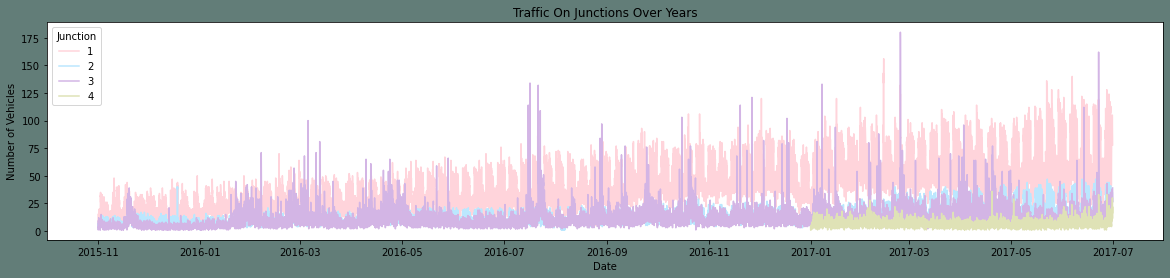

In [ ]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


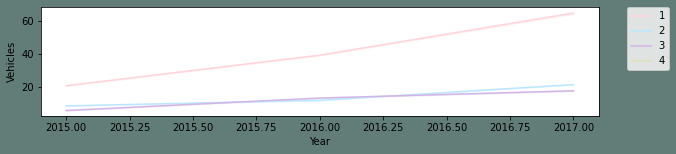

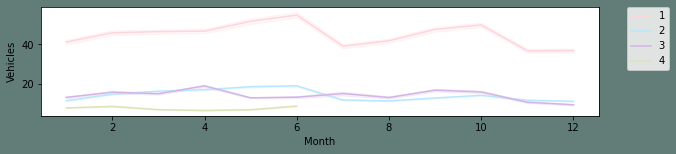

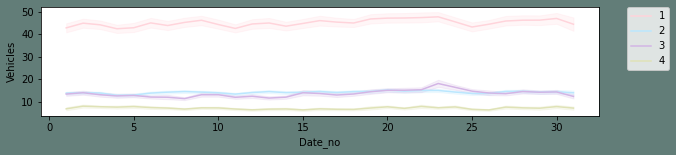

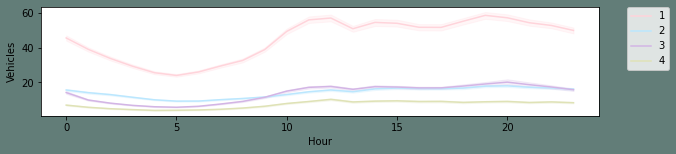

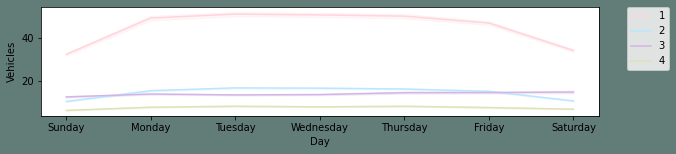

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

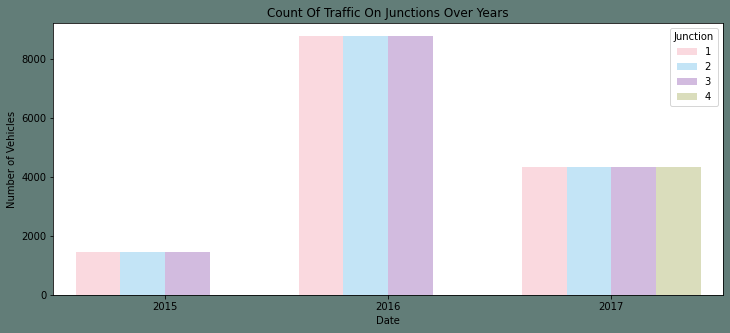

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

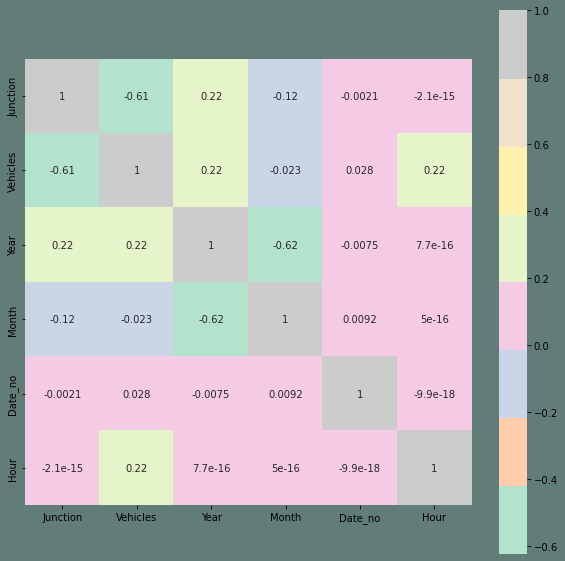

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

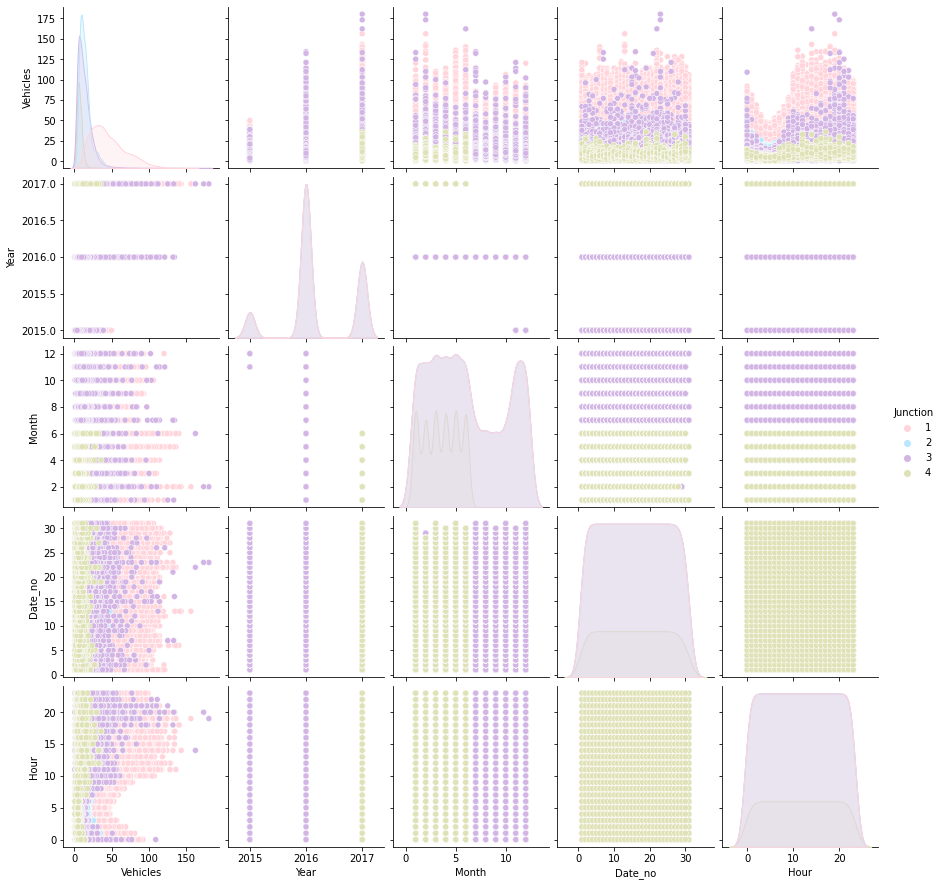

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [ ]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

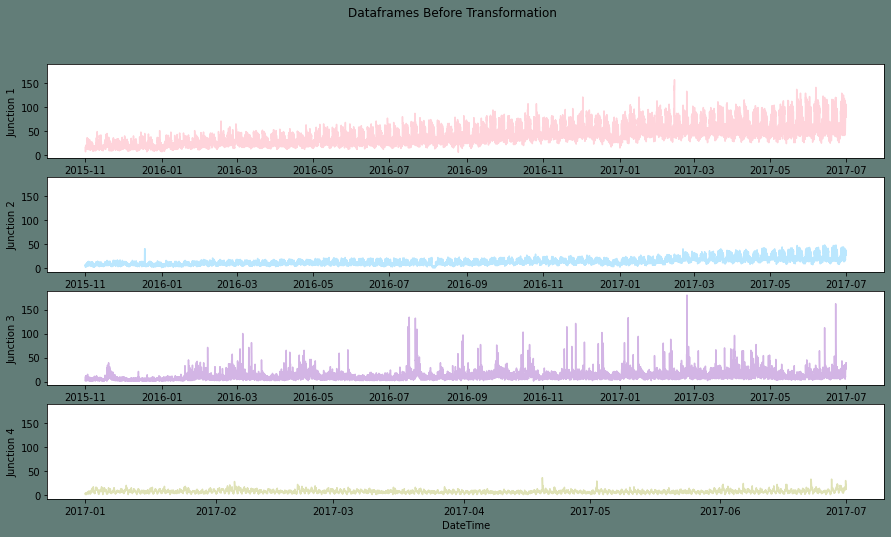

In [ ]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


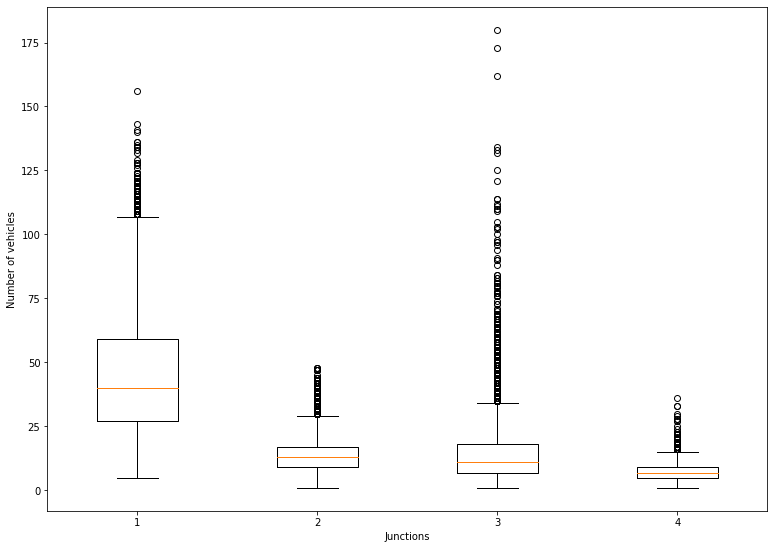

In [ ]:
# Box plot before normalization for vehicles

data = [df_1, df_2, df_3, df_4]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
plt.xlabel('Junctions')
plt.ylabel('Number of vehicles')
# show plot
plt.show()

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

<ipython-input-40-db733117bb69>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N1["Diff"]= Diff_1
<ipython-input-40-db733117bb69>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N2["Diff"]= Diff_2


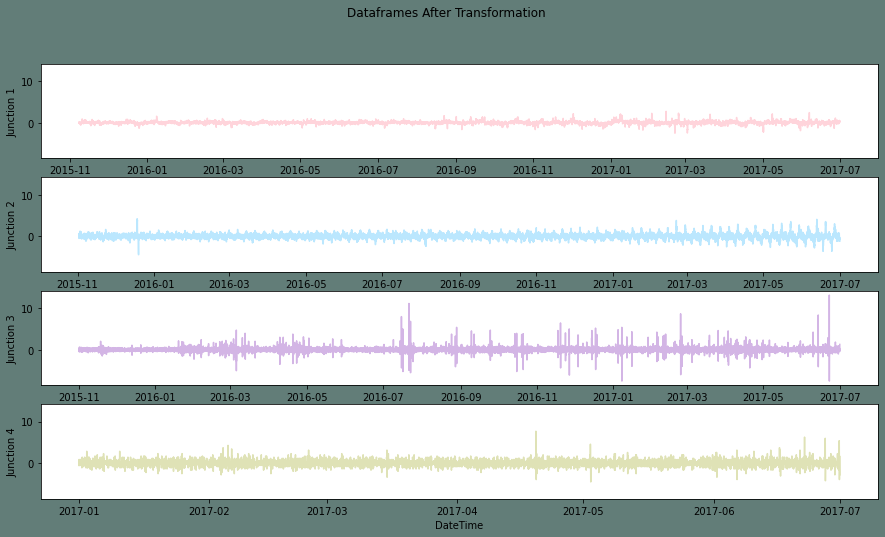

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [ ]:
df_N1

,Norm,Diff
DateTime,,
2015-11-08 00:00:00,-1.393099,-0.086925
2015-11-08 01:00:00,-1.262712,0.130387
2015-11-08 02:00:00,-1.480024,0.043462
2015-11-08 03:00:00,-1.610412,0.043462
2015-11-08 04:00:00,-1.523487,0.043462
...,...,...
2017-06-30 19:00:00,2.605450,0.478087
2017-06-30 20:00:00,2.214288,0.260775
2017-06-30 21:00:00,1.953513,0.391162


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


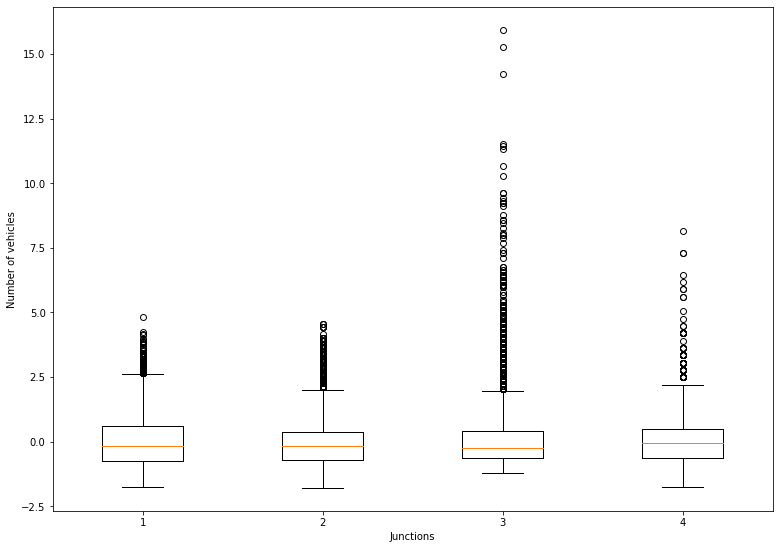

In [ ]:
# Box plot after normalization

data = [df_N1.Norm, df_N2.Norm, df_N3.Norm, df_N4.Norm]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
plt.xlabel('Junctions')
plt.ylabel('Number of vehicles')
# show plot
plt.show()

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415504
p-value: 4.798539876395756e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694011
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832504
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305238
p-value: 2.7787875325952613e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [ ]:
X_testJ1.shape

(1411, 32, 1)

In [ ]:
df_J1

,Diff
DateTime,
2015-11-08 00:00:00,-0.086925
2015-11-08 01:00:00,0.130387
2015-11-08 02:00:00,0.043462
2015-11-08 03:00:00,0.043462
2015-11-08 04:00:00,0.043462
...,...
2017-06-30 19:00:00,0.478087
2017-06-30 20:00:00,0.260775
2017-06-30 21:00:00,0.391162


In [ ]:
X_trainJ1

array([[[-0.08692498],
        [ 0.13038747],
        [ 0.04346249],
        ...,
        [-0.13038747],
        [-0.21731246],
        [-0.17384997]],

       [[ 0.13038747],
        [ 0.04346249],
        [ 0.04346249],
        ...,
        [-0.21731246],
        [-0.17384997],
        [-0.04346249]],

       [[ 0.04346249],
        [ 0.04346249],
        [ 0.04346249],
        ...,
        [-0.17384997],
        [-0.04346249],
        [-0.21731246]],

       ...,

       [[-0.43462491],
        [-0.21731246],
        [-0.69539986],
        ...,
        [-1.13002477],
        [-2.26004955],
        [-0.69539986]],

       [[-0.21731246],
        [-0.69539986],
        [-0.43462491],
        ...,
        [-2.26004955],
        [-0.69539986],
        [-0.78232484]],

       [[-0.69539986],
        [-0.43462491],
        [-0.4780874 ],
        ...,
        [-0.69539986],
        [-0.78232484],
        [-0.65193737]]])

In [ ]:
from tensorflow.keras.layers import Activation

In [ ]:

#Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test):
    
    #The LSTM model 
    model= Sequential()
    model.add(LSTM(units=32,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(LSTM(units=64,kernel_initializer='glorot_uniform',return_sequences=True, activation='tanh'))
    model.add(LSTM(units=128,kernel_initializer='glorot_uniform',return_sequences=True, activation='tanh'))
    model.add(LSTM(units=256,kernel_initializer='glorot_uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(X_Train, y_Train,epochs=50, batch_size=150, verbose=1)
    pred_LSTM= model.predict(X_Test)
    
    return pred_LSTM

    #To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To calculate the mean squred error in predictions
def MSE_Value(test,predicted):
    mse = mean_squared_error(test, predicted)
    print("The mean squared error is {}.".format(mse))
    return mse

#To calculate the mean absolute error in predictions
def MAE_Value(test,predicted):
    mae = mean_absolute_error(test, predicted)
    print("The mean absolute error is {}.".format(mae))
    return mae

#To calculate the mean absolute percentage error in predictions
def MAPE_Value(test, predicted): 
    mape = mean_absolute_percentage_error(test, predicted)
    print("The mean absolute percentage error is {}.".format(mape))
    return mape

#To calculate the r2 score in predictions
def R2_Value(test, predicted):
    r2 = r2_score(test, predicted)
    print("The r2 score is {}.".format(r2))
    return r2

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("LSTM Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()


In [ ]:
#Predictions For First Junction
PredJ1 = LSTM_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 [==============================] - 6s 14ms/step - loss: 0.0669
Epoch 2/50
87/87 [==============================] - 1s 13ms/step - loss: 0.0510
Epoch 3/50
87/87 [==============================] - 1s 13ms/step - loss: 0.0453
Epoch 4/50
87/87 [==============================] - 1s 13ms/step - loss: 0.0440
Epoch 5/50
87/87 [==============================] - 1s 14ms/step - loss: 0.0440
Epoch 6/50
87/87 [==============================] - 1s 13ms/step - loss: 0.0437
Epoch 7/50
87/87 [==============================] - 1s 13ms/step - loss: 0.0434
Epoch 8/50
87/87 [==============================] - 1s 14ms/step - loss: 0.0437
Epoch 9/50
87/87 [==============================] - 1s 14ms/step - loss: 0.0431
Epoch 10/50
87/87 [==============================] - 1s 14ms/step - loss: 0.0433
Epoch 11/50
87/87 [==============================] - 1s 14ms/step - loss: 0.0436
Epoch 12/50
87/87 [==============================] - 1s 14ms/step - loss: 0.0435
Epoch 13/50
87/87 [==================

The mean absolute error is 0.17284086779096622.
The mean absolute percentage error is 40482211677171.19.
The mean squared error is 0.05780637178531083.
The root mean squared error is 0.24042955680471326.
The r2 score is 0.5105223124019822.


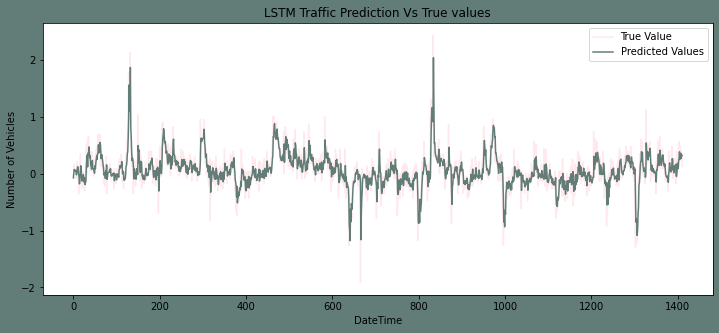

In [ ]:
#Results for J1 
MAE_J1 = MAE_Value(y_testJ1,PredJ1)
MAPE_J1 = MAPE_Value(y_testJ1,PredJ1)
MSE_J1 = MSE_Value(y_testJ1,PredJ1)
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
R2_J1 = R2_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [ ]:
#Predictions For Second Junction
PredJ2 = LSTM_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 [==============================] - 6s 15ms/step - loss: 0.2210
Epoch 2/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1886
Epoch 3/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1820
Epoch 4/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1770
Epoch 5/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1730
Epoch 6/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1705
Epoch 7/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1716
Epoch 8/50
88/88 [==============================] - 1s 13ms/step - loss: 0.1694
Epoch 9/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1688
Epoch 10/50
88/88 [==============================] - 1s 13ms/step - loss: 0.1668
Epoch 11/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1684
Epoch 12/50
88/88 [==============================] - 1s 14ms/step - loss: 0.1672
Epoch 13/50
88/88 [==================

The mean absolute error is 0.3737627301522745.
The mean absolute percentage error is 85049753074884.89.
The mean squared error is 0.22722292596582935.
The root mean squared error is 0.4766790597098108.
The r2 score is 0.7625804415561845.


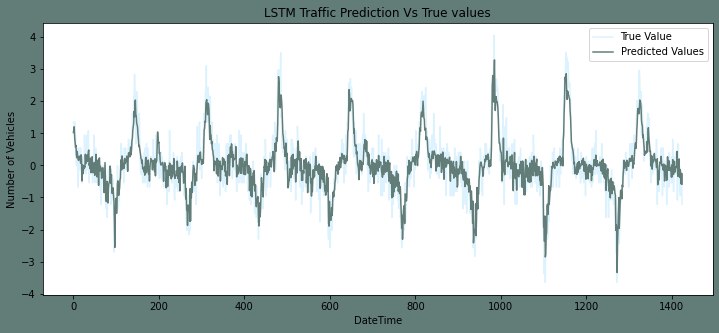

In [ ]:
#Results for J2
MAE_J2 = MAE_Value(y_testJ2,PredJ2)
MAPE_J2 = MAPE_Value(y_testJ2,PredJ2)
MSE_J2 = MSE_Value(y_testJ2,PredJ2)
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
R2_J2 = R2_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [ ]:
#Predictions For Third Junction
PredJ3 = LSTM_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
88/88 [==============================] - 6s 15ms/step - loss: 0.2863
Epoch 2/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2657
Epoch 3/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2642
Epoch 4/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2549
Epoch 5/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2472
Epoch 6/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2448
Epoch 7/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2394
Epoch 8/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2373
Epoch 9/50
88/88 [==============================] - 1s 13ms/step - loss: 0.2374
Epoch 10/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2356
Epoch 11/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2336
Epoch 12/50
88/88 [==============================] - 1s 13ms/step - loss: 0.2341
Epoch 13/50
88/88 [==================

The mean absolute error is 0.27407322555836605.
The mean absolute percentage error is 65904149153351.12.
The mean squared error is 0.32014510115724587.
The root mean squared error is 0.5658136629291006.
The r2 score is 0.20575795025259735.


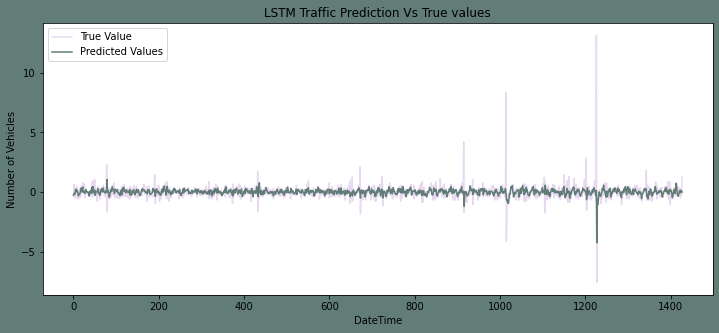

In [ ]:
#Results for J3
MAE_J3 = MAE_Value(y_testJ3,PredJ3)
MAPE_J3 = MAPE_Value(y_testJ3,PredJ3)
MSE_J3 = MSE_Value(y_testJ3,PredJ3)
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
R2_J3 = R2_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [ ]:
#Predictions For Forth Junction
PredJ4 = LSTM_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 [==============================] - 5s 17ms/step - loss: 0.6764
Epoch 2/50
26/26 [==============================] - 0s 13ms/step - loss: 0.6709
Epoch 3/50
26/26 [==============================] - 0s 14ms/step - loss: 0.6681
Epoch 4/50
26/26 [==============================] - 0s 14ms/step - loss: 0.6690
Epoch 5/50
26/26 [==============================] - 0s 14ms/step - loss: 0.6510
Epoch 6/50
26/26 [==============================] - 0s 14ms/step - loss: 0.6026
Epoch 7/50
26/26 [==============================] - 0s 14ms/step - loss: 0.5074
Epoch 8/50
26/26 [==============================] - 0s 13ms/step - loss: 0.4819
Epoch 9/50
26/26 [==============================] - 0s 14ms/step - loss: 0.4722
Epoch 10/50
26/26 [==============================] - 0s 14ms/step - loss: 0.4631
Epoch 11/50
26/26 [==============================] - 0s 13ms/step - loss: 0.4620
Epoch 12/50
26/26 [==============================] - 0s 14ms/step - loss: 0.4502
Epoch 13/50
26/26 [==================

The mean absolute error is 0.6837050070341635.
The mean absolute percentage error is 205149058273819.5.
The mean squared error is 0.9705101790103265.
The root mean squared error is 0.9851447502830873.
The r2 score is 0.22109504365495325.


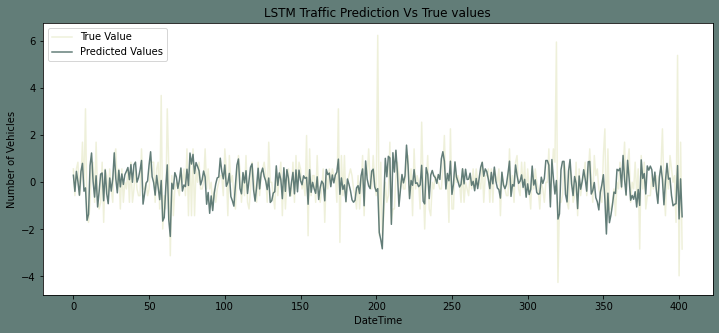

In [ ]:
#Results for J4
MAE_J4 = MAE_Value(y_testJ4,PredJ4)
MAPE_J4 = MAPE_Value(y_testJ4,PredJ4)
MSE_J4 = MSE_Value(y_testJ4,PredJ4)
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
R2_J4 = R2_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [ ]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

In [ ]:
df_N1.Norm.shape

(14424,)

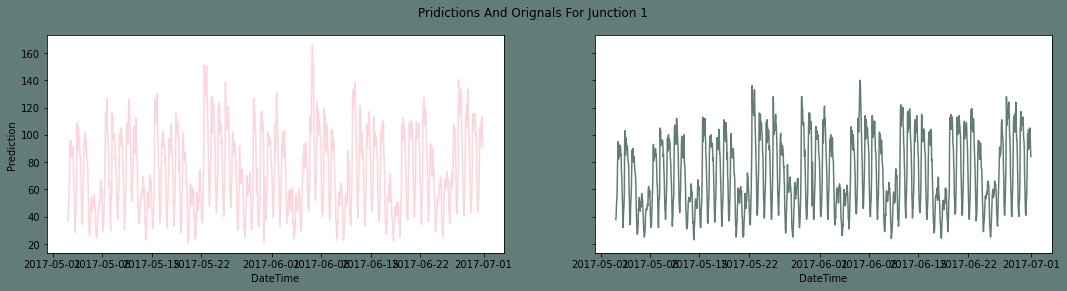

In [ ]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

In [ ]:
df_N2.shape

(14568, 2)

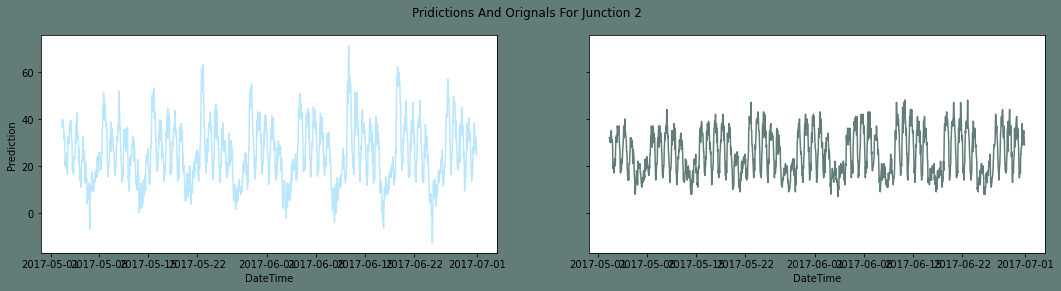

In [ ]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

In [ ]:
df_N3.shape

(14591, 2)

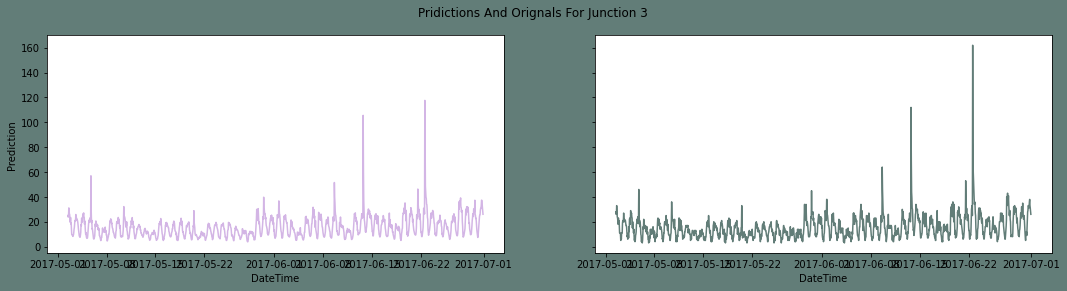

In [ ]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

In [ ]:
df_N4.shape

(4343, 2)

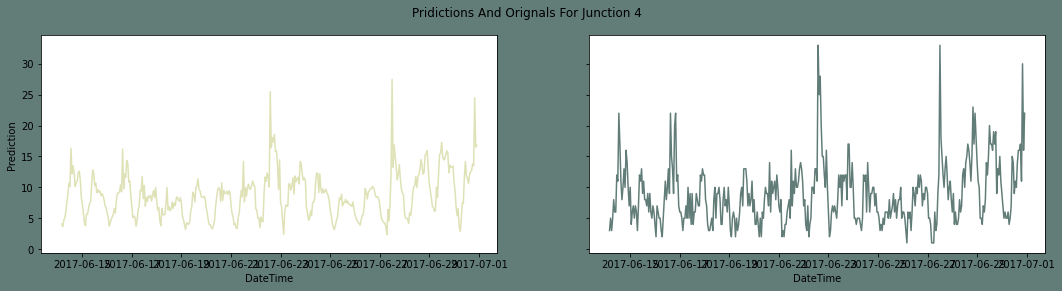

In [ ]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)